In [ ]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#Install miniconda and rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2019-10-30 11:30:37--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  68.46M   126MB/s    in 0.5s    

2019-10-30 11:30:38 (126 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_

In [ ]:
#Read smiles files
maxlen = 64
with open('/content/gdrive/My Drive/Colab Notebooks/smiles.txt') as f:
  smiles = f.readlines()[:]
  smiles = [s.strip() for s in smiles]
  smiles = [s.split()[1] for s in smiles]
  smiles = [s for s in smiles if len(s)<maxlen]

#Characters of smiles
all_smiles=''
for s in smiles: all_smiles+=s
chars = sorted(list(set(list(all_smiles))))
chars.append('X')
c_to_i = {c:i for i,c in enumerate(chars)}
print ('Max len:', maxlen)
print ('Number of chars:', len(chars))
print (chars)
print (c_to_i)
print (len(smiles))

Max len: 64
Number of chars: 46
['#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '=', '@', 'B', 'C', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'S', 'V', 'Z', '[', '\\', ']', 'a', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'r', 's', 'u', 'X']
{'#': 0, '(': 1, ')': 2, '+': 3, '-': 4, '.': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '=': 14, '@': 15, 'B': 16, 'C': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'K': 22, 'L': 23, 'M': 24, 'N': 25, 'O': 26, 'P': 27, 'S': 28, 'V': 29, 'Z': 30, '[': 31, '\\': 32, ']': 33, 'a': 34, 'c': 35, 'e': 36, 'g': 37, 'i': 38, 'l': 39, 'n': 40, 'o': 41, 'r': 42, 's': 43, 'u': 44, 'X': 45}
448984


In [ ]:
#Calculate Morgan fingerprints and LogP of each molecule
from rdkit import Chem
from rdkit.Chem.Crippen import MolLogP
import numpy as np
import torch
import time

Y = []
num_data = 20000
st = time.time()
for s in smiles[:num_data]:
  m = Chem.MolFromSmiles(s)
  logp = MolLogP(m)
  Y.append(logp)
end = time.time()

print (f'Time:{(end-st):.3f}')

Time:14.420


In [ ]:
#Dataset
from torch.utils.data import Dataset, DataLoader

class MolDataset(Dataset):
    def __init__(self, smiles, properties, c_to_i, maxlen):
      self.c_to_i = c_to_i
      self.maxlen = maxlen
      self.smiles = smiles
      self.properties = properties
      
    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        s = self.smiles[idx]
        s = s.ljust(self.maxlen, 'X') #fill with X until s to be 64
        i = torch.from_numpy(np.array([c_to_i[c] for c in s]))
        sample = dict()
        sample['X'] = i
        sample['Y'] = self.properties[idx]
        return sample

In [ ]:
#Model

import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvRegressor(torch.nn.Module):
  def __init__(self, n_channel=128, n_conv_layer = 10, kernel_size=3, n_char=46, n_skip=2, mode = 'zeros', stride = 1, pooling = False, dropout = False):
    super(ConvRegressor, self).__init__()

    if (mode == 'circular'):
      self.conv = nn.ModuleList([nn.Conv1d(n_channel, n_channel, kernel_size, \
                                          1, padding = kernel_size//2 * 2, padding_mode = 'circular') \
                                for i in range(n_conv_layer)])
        
    else:
      self.conv = nn.ModuleList([nn.Conv1d(n_channel, n_channel, kernel_size, \
                                          1, padding = kernel_size//2, padding_mode = 'zeros') \
                                for i in range(n_conv_layer)])

    if(stride != 1 or pooling): 
      if(pooling):
        self.conv.insert(0, nn.MaxPool1d(kernel_size, stride, padding = kernel_size//2))
      
      else:
        self.conv.insert(0, nn.Conv1d(n_channel, n_channel, kernel_size, stride, padding = kernel_size//2))
       
      self.mode = True
      self.fc = nn.Linear((maxlen + kernel_size//2 * 2) // stride * n_channel, 1)


    else:
      self.mode = False
      self.fc = nn.Linear(maxlen*n_channel, 1)


    self.embedding = nn.Embedding(n_char, n_channel)
    self.n_skip = n_skip
    self.dropout = dropout
    self.dropfunc = nn.Dropout(0.2)
    

  def forward(self, x):
    x = self.embedding(x)
    x = x.permute((0,2,1))
    before_x = x


    for i,l in enumerate(self.conv):
      # input_x = x
      # x = F.relu(l(x))

      # if i%3 == 2:
      #   x += input_x
      #   input_x = x
      x = l(x)

      if(self.mode and i == 0):
        before_x = x

      #print(before_x, x, 'before if')
      if i%self.n_skip == 1:
        x = F.relu(x + before_x)
        before_x = x
        #print(before_x, x, 'after skip connection')
        
      else:
        x = F.relu(x)
        
    x = x.view(x.size(0), -1)


    if self.dropout:
      x = self.dropfunc(x)

    x = self.fc(x)

    return x


class Inception(torch.nn.Module):
  def __init__(self, n_channel=128, n_conv_layer = 10, kernel_size= [3, 5], n_char=46, n_skip=2, mode = 'zeros', dropout = False):
    super(Inception, self).__init__()

    if(mode == 'circular'):
      self.conv = nn.ModuleList([nn.Conv1d(n_channel, n_channel, kernel_size[j], \
                                          1, padding = kernel_size[j]//2 *2, padding_mode = 'circular') \
                                for j in range(len(kernel_size)) \
                                for i in range(n_conv_layer)])
    
    else:
      self.conv = nn.ModuleList([nn.Conv1d(n_channel, n_channel, kernel_size[j], \
                                          1, padding = kernel_size[j]//2, padding_mode = 'zeros') \
                                for j in range(len(kernel_size)) \
                                for i in range(n_conv_layer)])
    self.fc = nn.Linear(maxlen*n_channel*len(kernel_size), 1)
    self.embedding = nn.Embedding(n_char, n_channel)
    self.n_skip = n_skip
    self.kernel_size = len(kernel_size)
    self.n_conv_layer = n_conv_layer
    self.dropout = dropout
    self.dropfunc = nn.Dropout(0.2)

  def forward(self, x):
    x = self.embedding(x)
    x = x.permute((0,2,1))
    before_x = x
    using_x = x
    retval = torch.empty(x.size(0), x.size(1) * x.size(2))
    retval = retval.cuda()
    tensors = []

    for i in range(self.kernel_size):
      x = using_x
      before_x = using_x

      for j in range(self.n_conv_layer):
        x = self.conv[i*self.n_conv_layer + j](x)
        
        if j%self.n_skip == 1:
          x = F.relu(x + before_x)
          before_x = x

        else:
          x = F.relu(x)

      x = x.view(x.size(0), -1)
      tensors.append(x)
      
    retval = torch.cat(tensors, 1)

    if self.dropout:
      x = self.dropfunc(x)

    retval = self.fc(retval)
    return retval

In [ ]:
#Train model
import time
lr = 1e-4
model_3 = ConvRegressor(128, 10, 3, 46)
model_3_dropout = ConvRegressor(128, 10, 3, 46, dropout = True)
model_5 = ConvRegressor(128, 10, 5, 46)
model_3_skip3 = ConvRegressor(128, 10, 3, 46, n_skip = 3)
#model_5_skip3 = ConvRegressor(128, 10, 5, 46, n_skip = 3)
model_3_cir = ConvRegressor(128, 10, 3, 46, mode = 'circular')
#model_5_cir = ConvRegressor(128, 10, 5, 46, mode = 'circular')
#model_3_skip3_cir = ConvRegressor(128, 10, 3, 46, n_skip = 3, mode = 'circular')
#model_5_skip3_cir = ConvRegressor(128, 10, 5, 46, n_skip = 3, mode = 'circular')

model_3_pool = ConvRegressor(128, 10, 3, 46, pooling = True, stride = 3)
model_3_stride3 = ConvRegressor(128, 10, 3, 46, stride = 3)

model_inception_ker_5 = Inception(128, 10, [3, 5], 46, dropout = True)
model_inception_ker_7 = Inception(128, 10, [3, 5, 7], 46,  dropout = True)
model_inception_ker_9 = Inception(128, 10, [3, 5, 7, 9], 46, mode = 'circular')

model_list = [model_inception_ker_5, model_inception_ker_7] 

# model_list = [model_3, model_3_dropout,
#               model_5, model_3_skip3, model_3_cir,
#               model_3_pool, model_3_stride3,
#               model_inception_ker_5, model_inception_ker_7, model_inception_ker_9] 

result = []


#Dataset
train_smiles = smiles[:19000]
test_smiles = smiles[19000:20000]
train_logp = Y[:19000]
test_logp = Y[19000:20000]
train_dataset = MolDataset(train_smiles, train_logp, c_to_i, maxlen)
test_dataset = MolDataset(test_smiles, test_logp, c_to_i, maxlen)

#Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=128, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=128, num_workers=1)

loss_fn = nn.MSELoss()

def train(model):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  #optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  loss_list = []
  st = time.time()


  model = model.cuda()
  #print(model.__class__.__name__)
  for epoch in range(5):
    epoch_loss = []
    for i_batch, batch in enumerate(train_dataloader):
      x, y = batch['X'].cuda(), batch['Y'].cuda()
      x = x.long()
      y = y.float()
      pred = model(x)
      pred = pred.squeeze(-1)
      loss = loss_fn(pred, y)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #limit gradient to 1
      optimizer.step()
      loss_list.append(loss.data.cpu().numpy())
      epoch_loss.append(loss.data.cpu().numpy())
    if True: print (epoch, np.mean(np.array(epoch_loss)))
  end = time.time()
  print ('Time:', end-st, '\n\n')
  return model, loss_list

for i in model_list:
  result.append(train(i))

0 1.4716864
1 0.47423774
2 0.29605907
3 0.20019737
4 0.1425585
Time: 55.83345365524292 


0 1.4771348
1 0.44551557
2 0.22237732
3 0.21957193
4 0.19470745
Time: 95.54525995254517 




In [ ]:
#Save model
fn = '/content/gdrive/My Drive/save.pt'
torch.save(model.state_dict(), fn)

NameError: ignored

In [ ]:
#Load model
model.load_state_dict(torch.load(fn))

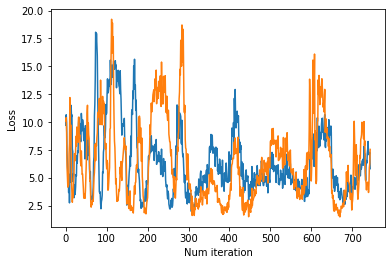

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(result)):
  plt.plot(result[i][1])
  plt.xlabel('Num iteration')
  plt.ylabel('Loss')


In [ ]:
#Test model

def loss_check(model):
  model.eval()
  with torch.no_grad():
    y_pred_train, y_pred_test = [], []
    loss_train, loss_test = [], []
    pred_train, pred_test = [], []
    true_train, true_test = [], []

    
    for sample in train_dataloader:
      x, y = sample['X'].cuda(), sample['Y'].cuda().float()
      pred = model(x).squeeze(-1)
      pred_train.append(pred.data.cpu().numpy())
      true_train.append(y.data.cpu().numpy())

      loss_train.append(loss_fn(y, pred).data.cpu().numpy())
    
    for sample in test_dataloader:
      x, y = sample['X'].cuda(), sample['Y'].cuda().float()
      pred = model(x).squeeze(-1)
      pred_test.append(pred.data.cpu().numpy())
      true_test.append(y.data.cpu().numpy())
      loss_test.append(loss_fn(y, pred).data.cpu().numpy())

  pred_train = np.concatenate(pred_train, -1)
  pred_test = np.concatenate(pred_test, -1)
  true_train = np.concatenate(true_train, -1)
  true_test = np.concatenate(true_test, -1)
      
  print ('Train loss:', np.mean(loss_train))
  print ('Test loss:', np.mean(loss_test), '\n\n')
  
for i in range(len(result)):
  loss_check(result[i][0])

Train loss: 0.096180886
Test loss: 0.09793341 


Train loss: 0.49905223
Test loss: 0.5135008 




Text(0, 0.5, 'Pred')

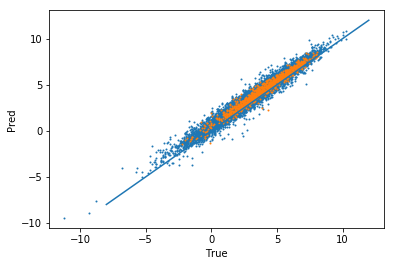

In [ ]:

plt.scatter(true_train, pred_train, s=1)
plt.scatter(true_test, pred_test, s=1)

plt.plot([-8,12], [-8,12])
plt.xlabel('True')
plt.ylabel('Pred')
